<div style="border:solid  green  2px; padding: 20px"> <h1 style="color: green">Анализ оттока сети  фитнес-центров</h1>

# Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных. 

Цель: провести анализ и подготовить план действий по удержанию клиентов. 
Задачи:
    - научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
    - сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их 
    основные  свойства;
    - проанализировать основные признаки, наиболее сильно влияющие на отток;
    - сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
        1) выделить целевые группы клиентов;
        2) предложить меры по снижению оттока;
        3) определить другие особенности взаимодействия с клиентами.

# Описание данных

Данные для анализа - csv-файл, который содержит данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:

            'Churn' — факт оттока в текущем месяце;
        Текущие поля в датасете:
        Данные пользователя за предыдущий до проверки факта оттока месяц:
            'gender' — пол
            'Near_Location' — проживание или работа в районе, где находится фитнес-центр
            'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать 
            скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
            Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от 
            знакомого при оплате первого абонемента)
            'Phone' — наличие контактного телефона
            'Age' — возраст
            'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)
    Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента
        'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
        'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
        'Group_visits' — факт посещения групповых занятий
        'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
        'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
        'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, 
        косметический и массажный салон

# План действий

1. Исследовательский анализ данных
2. Построение модели прогнозирования оттока пользователей
3. Кластеризация пользователей
4. Выводы и базовые рекомендации

In [4]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display


# Исследовательский анализ данных

In [5]:
pd.set_option('display.float_format', lambda x: '%.3f' % x) #изменение глобальной настройки отображения 

In [6]:
fit_data = pd.read_csv('/datasets/gym_churn.csv') # переменная с исходными данными

In [7]:
fit_data.head(15)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227,5.000,3,0.020,0.000,0
1,0,1,0,0,1,12,1,31,113.203,12.000,7,1.923,1.910,0
2,0,1,1,0,1,1,0,28,129.448,1.000,2,1.859,1.737,0
3,0,1,1,1,1,12,1,33,62.670,12.000,2,3.206,3.357,0
4,1,1,1,1,1,1,0,26,198.362,1.000,3,1.114,1.120,0
5,1,1,0,0,1,1,1,34,450.744,1.000,3,2.623,2.637,0
6,1,1,1,1,0,6,1,32,94.266,6.000,2,1.139,1.277,0
7,0,1,0,0,1,1,0,30,217.787,1.000,0,1.214,1.049,1
8,1,1,1,1,1,1,1,23,45.410,1.000,1,1.106,1.059,0
9,0,1,0,0,1,1,0,31,65.311,1.000,11,1.811,1.951,0


In [8]:
fit_data.columns = fit_data.columns.str.lower() #приводим заголовки к нижнему регистру

In [9]:
fit_data.info() #изучаем основную информацию и размер датасета
fit_data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
contract_period                      4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null float64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


(4000, 14)

In [10]:
fit_data.isnull().sum() #пропущенных значений не обнаружено

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

In [11]:
fit_data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000
mean,0.510,0.845,0.487,0.308,0.903,4.681,0.412,29.184,146.944,4.323,3.725,1.879,1.767,0.265
std,0.500,0.362,0.500,0.462,0.295,4.550,0.492,3.258,96.356,4.191,3.749,0.972,1.053,0.442
min,0.000,0.000,0.000,0.000,0.000,1.000,0.000,18.000,0.148,1.000,0.000,0.000,0.000,0.000
25%,0.000,1.000,0.000,0.000,1.000,1.000,0.000,27.000,68.869,1.000,1.000,1.181,0.963,0.000
50%,1.000,1.000,0.000,0.000,1.000,1.000,0.000,29.000,136.220,1.000,3.000,1.833,1.720,0.000
75%,1.000,1.000,1.000,1.000,1.000,6.000,1.000,31.000,210.950,6.000,5.000,2.536,2.510,1.000
max,1.000,1.000,1.000,1.000,1.000,12.000,1.000,41.000,552.591,12.000,31.000,6.024,6.147,1.000


In [12]:
fit_data.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510,0.873,0.534,0.354,0.904,5.747,0.464,29.977,158.446,5.283,4.712,2.025,2.028
1,0.511,0.768,0.355,0.184,0.903,1.729,0.269,26.990,115.083,1.663,0.991,1.475,1.045


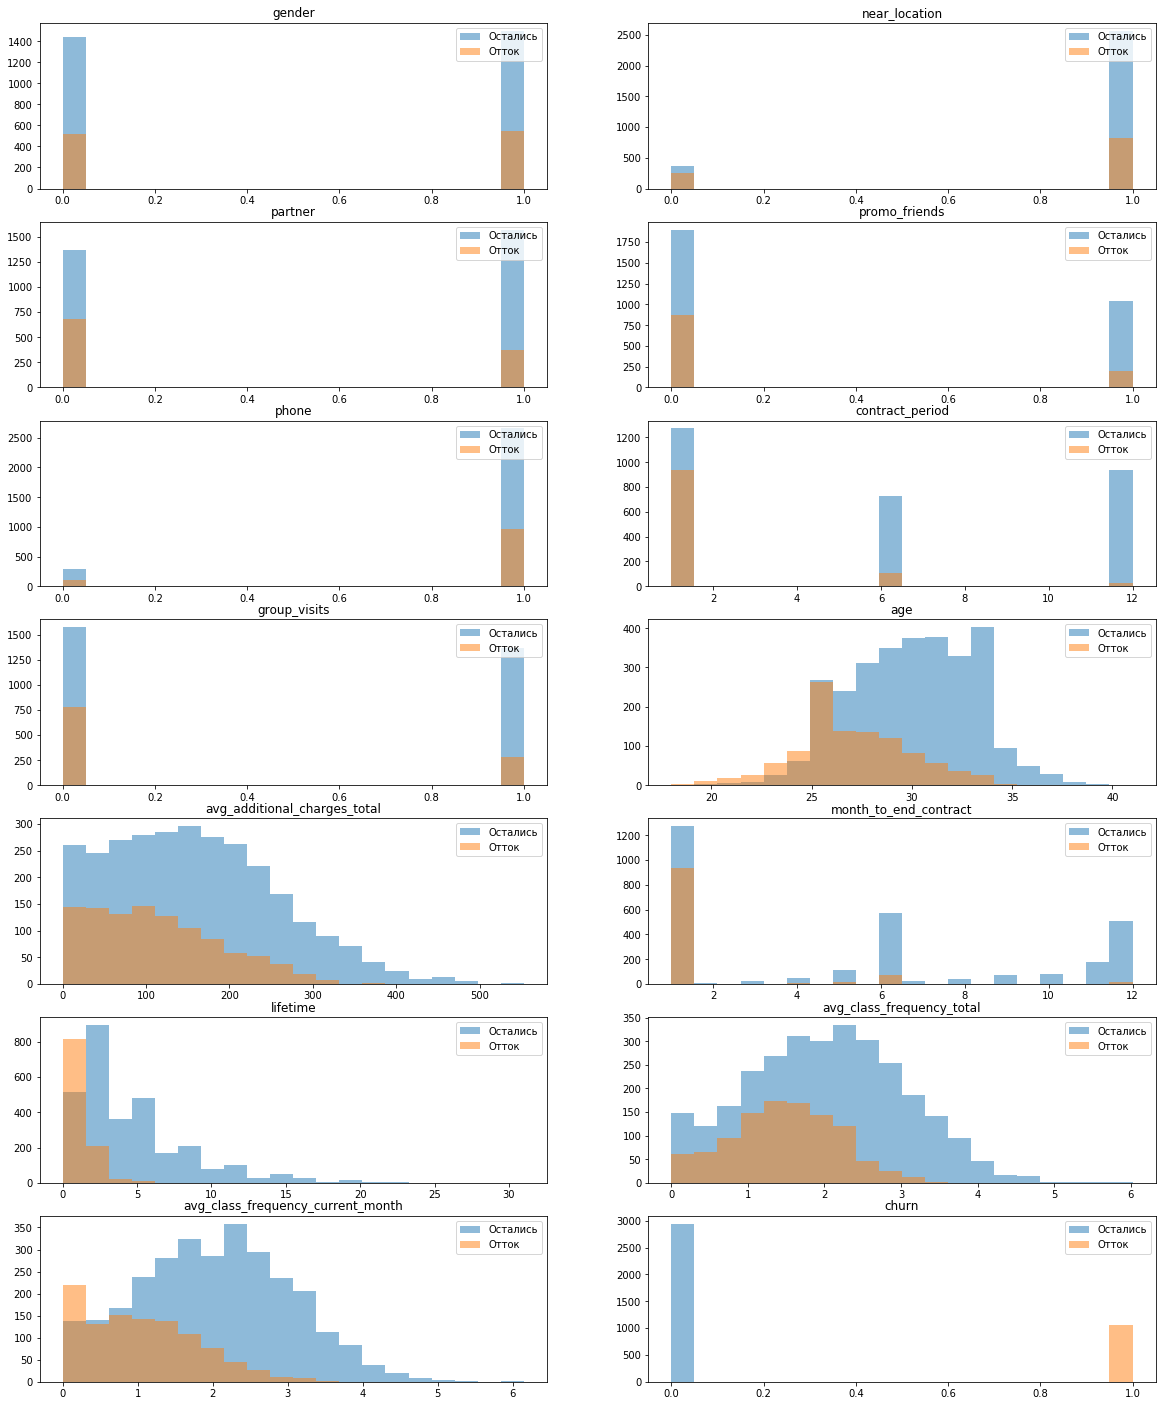

In [13]:
churn_0 = fit_data[fit_data['churn']==0]
churn_1 = fit_data[fit_data['churn']==1]

fig, ax = plt.subplots(7,2, figsize = (20, 25))
ax = ax.ravel()

for i in range(len(fit_data.columns)):
    col_name = fit_data.columns[i]
    range_hist = (fit_data[col_name].min(), fit_data[col_name].max())
    ax[i].hist(churn_0[col_name], bins=20, range =range_hist, alpha = 0.5, label = 'Остались')
    ax[i].hist(churn_1[col_name], bins=20, range =range_hist, alpha = 0.5, label = 'Отток')
    ax[i].legend(loc = 'upper right')
    ax[i].set_title(col_name)
plt.show()

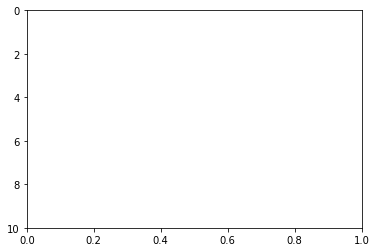

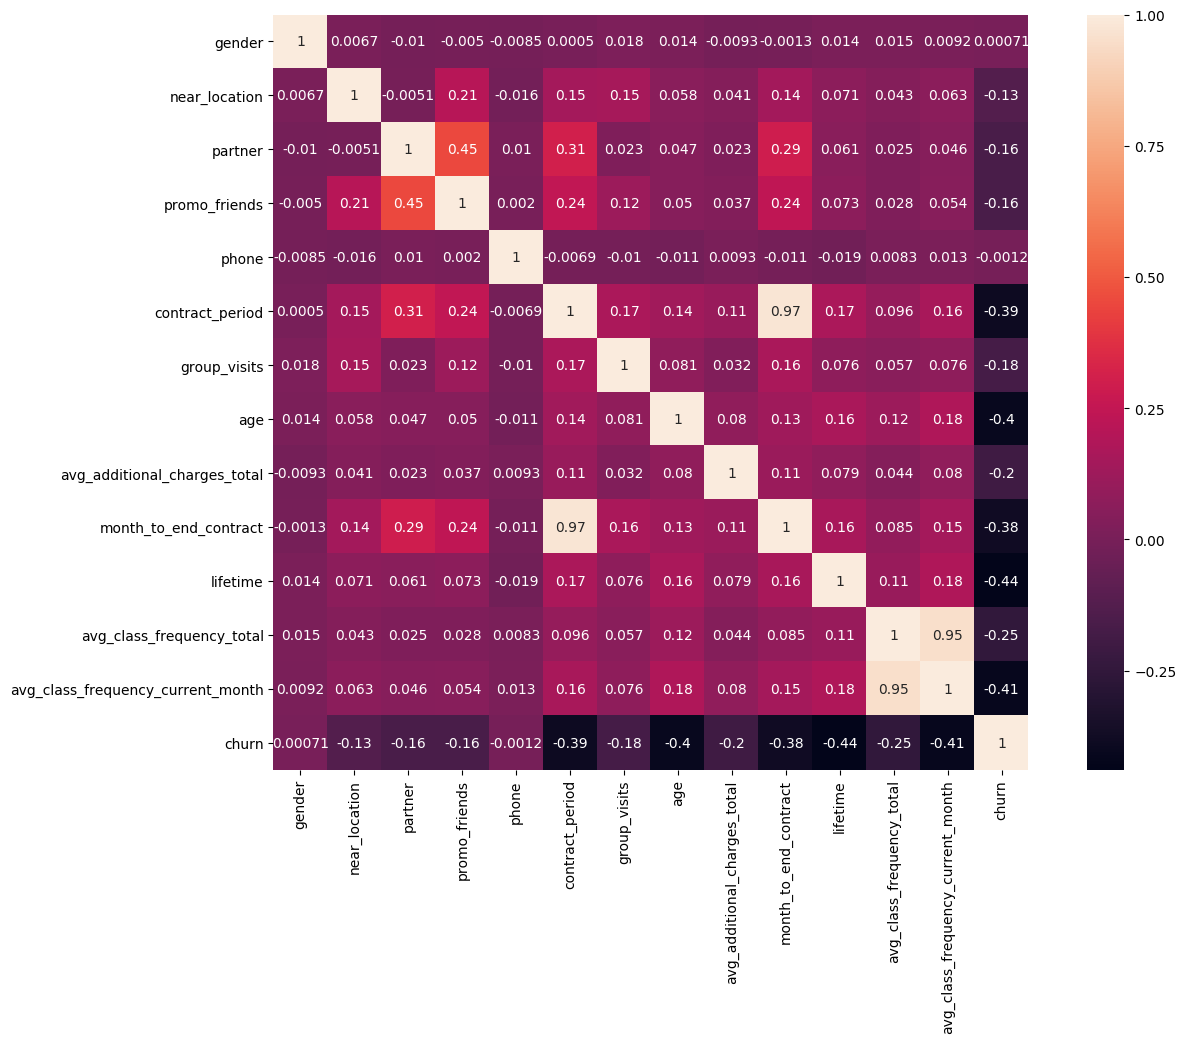

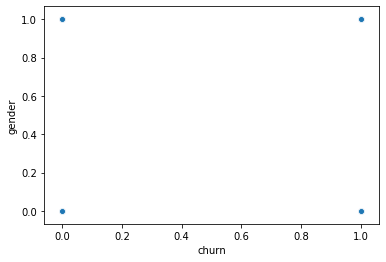

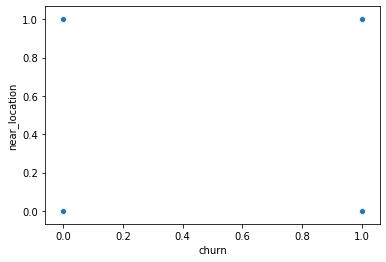

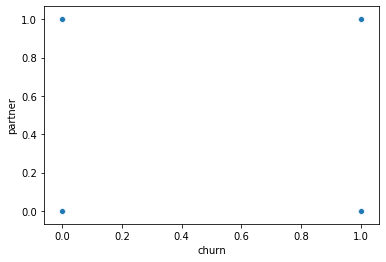

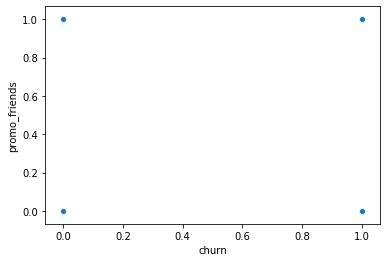

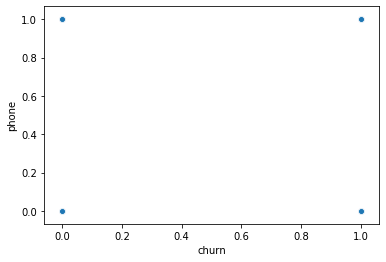

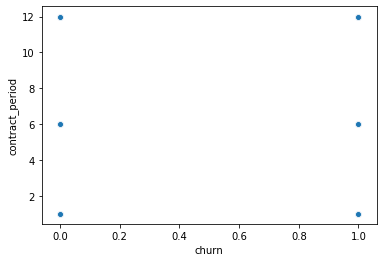

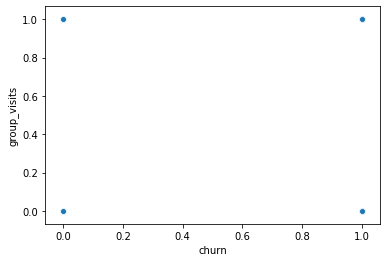

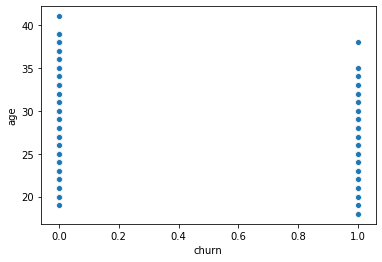

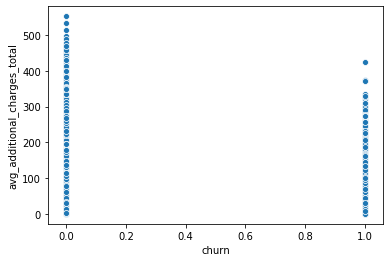

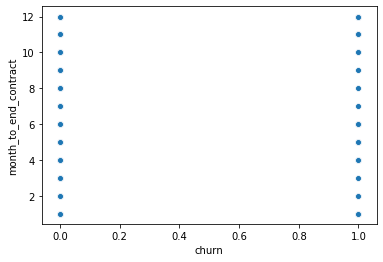

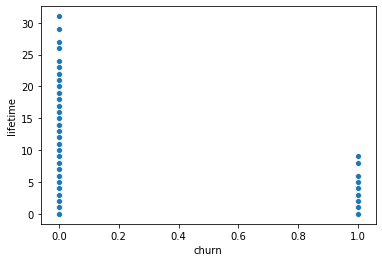

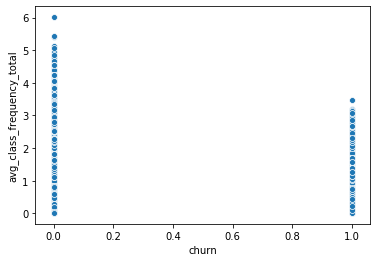

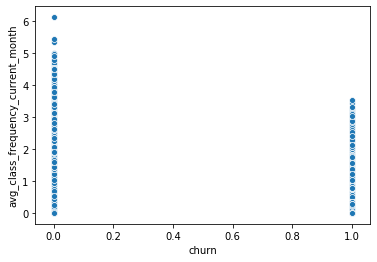

In [14]:
cm = fit_data.corr() #вычисляем матрицу корреляций
fig, ax = plt.subplots()

#нарисуем тепловую карту с подписями для матрицы корреляций
plt.figure(figsize = (15,10), dpi = 100)
sns.heatmap(cm, annot = True, square=True)#ваш код здесь
ax.set_ylim(10, 0) #корректировка "рваных" полей heatmap в последней версии библиотеки
plt.show()

for col in fit_data.drop('churn', axis = 1).columns:
    sns.scatterplot(fit_data['churn'], fit_data[col])#ваш код здесь
    plt.show()

# Выводы по блоку "Исследовательский анализ данных"

Данные проверены на наличие пропущенных значений;
Ярких выбросов и и перекосов по диаграммам рассеяния не наблюдается. Значит данные можем использовать для остроения модели;
Относительно корреляций и попарных признаков - признаки с бинарным составом не демострируют зависимости. Зато, некоторые численные показатели достаточно сильно коррелируют с целевой переменной. Скорее всего, чем чаще человек посещает зал, чем дольше является клиентом клуба и чем больше тратит - тем выше вероятность, что данный клиент останется клиентом и дальше. Результы выглядят правдоподобно. Даже не построив модели, только на основании EDA, уже можно предположить что влияет на целевую переменную "churn".  



# Построение модели прогнозирования оттока пользователей

In [15]:
#разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = fit_data.drop('churn', axis = 1)
y = fit_data['churn']

#разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [16]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_test, predictions, title = 'Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_test, predictions)))
    print('\tRecall: {:.2f}'.format(recall_score(y_test, predictions)))

In [17]:
#задаем алгоритм модели
model = LogisticRegression()
#обучаем модель
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:,1]

print_all_metrics(y_test, predictions, title='Метрики для модели логистической регрессии:')


Метрики для модели логистической регрессии:
	Accuracy: 0.93
	Precision: 0.86
	Recall: 0.83


In [19]:
# обучаем StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуйте обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [20]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)

rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

print_all_metrics(y_test, rf_predictions, title = 'Метрики для модели случайного леса:')


Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.81


# Вывод по блоку  "Построение модели прогнозирования оттока пользователей"

Метрики в рассматриваемых моделях практически совпадают (разница в сотой доле). Можно сделать вывод, что обе модели точные и подходят для работы. Для дальнейших действий, выберем логистическую регрессию, т.к. эта модель тренируется быстрее. 

# Кластеризация

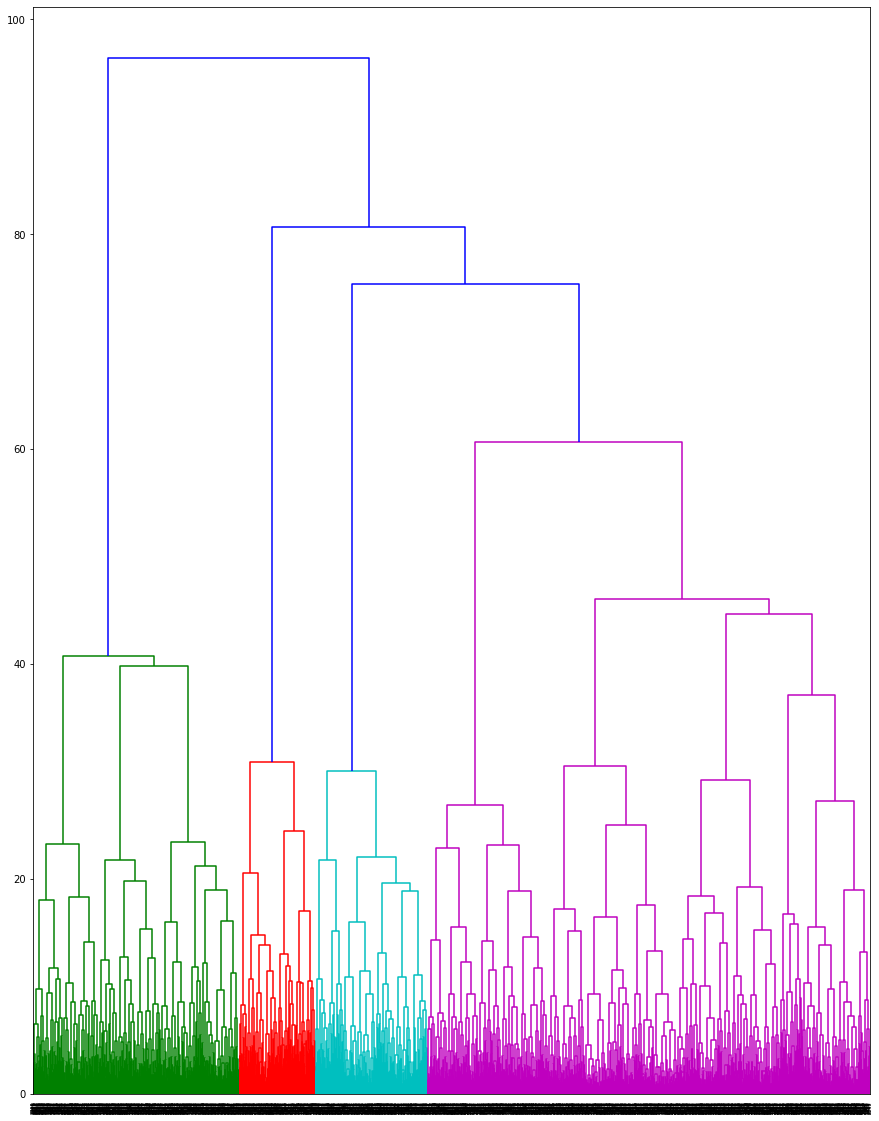

In [21]:
linkage_matrix = linkage(X_train_st, method = 'ward')

plt.figure(figsize = (15, 20))
dendrogram(linkage_matrix, orientation='top')
plt.show() #подождать +- 2 мин

In [22]:
X_st = StandardScaler().fit_transform(X)

In [23]:
km = KMeans(n_clusters = 5)
# прогнозируем кластеры для наблюдений 
labels = km.fit_predict(X_st)

# сохраняем метки кластера в поле нашего датасета
fit_data['clusters'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
print(fit_data.groupby(['clusters']).mean())

          gender  near_location  partner  promo_friends  phone  \
clusters                                                         
0          0.495          0.000    0.466          0.077  0.916   
1          0.484          0.998    0.822          1.000  0.900   
2          0.587          0.971    0.262          0.092  0.905   
3          0.501          0.946    0.742          0.487  0.900   
4          0.487          1.000    0.243          0.021  0.902   

          contract_period  group_visits    age  avg_additional_charges_total  \
clusters                                                                       
0                   2.228         0.215 28.484                       133.863   
1                   3.156         0.455 29.218                       141.203   
2                   2.820         0.479 30.130                       162.236   
3                  11.872         0.553 29.934                       164.763   
4                   1.981         0.319 28.219           

Есть кластеры в которые попали ТОЛЬКО те, кто живет или работает рядом с клубом и те, кто, наоборот, никак не привязан к клубу локацией. Оба кластера наиболее склонны к оттоку. Так, признак по близости можно не рассматривать, как влияющий на долю оттока, возможно, опираясь на него можно прогнозировать первичное привлечение клиента, но не удержание.

Привязку к корпоративной программе (признак "partner") имеет большинство представителей 4 кластера - "лидера" по удержанию клиентов. Вероятно, партнерская программа предлагает клиентам наиболее выгодные условия + знакомое сообщество по интересам.

Зависимость удержания от изначального привлечения другом - возможна, но подтверждается только одним кластером, а значит, зависимость не абсолютна.

Продолжительность клубной карты подтверждает свою значимость по отношению к целевой переменной. 

Возрастной признак показывает, что удерживаются кластеры со средним возрастом ближе к 30. Но, так как, возраст остальных клиастеров не сильно отличается, важно следить за другими признаками, смежными с возрастом. Например - время с первого посещения. Данный признак логичнее рассматривать в гистограмме распределения (см. блок "Исследовательский анализ данных"). Клиенты возрастом выше 25, чаще посещают спорт зал.

Прямая зависимость к целевой переменной у признака - суммарная выручка от доппродуктов. Проверенное правило - чем чаще человек платит, тем он лояльнее. 

Признак lifetime - так же имеет сильную зависимость. Чем клиент дольше является клиентом, тем сложнее ему отказаться от услуг.

Признаки по частоте посещений так же имеют сильное влияние на отток.



In [24]:
def show_clusters_on_plot(df, x_name,y_name, cluster_name):
    plt.figure(figsize = (10,10))
    sns.scatterplot(df[x_name], df[y_name],
           hue = df[cluster_name], palette = 'Paired'
       )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

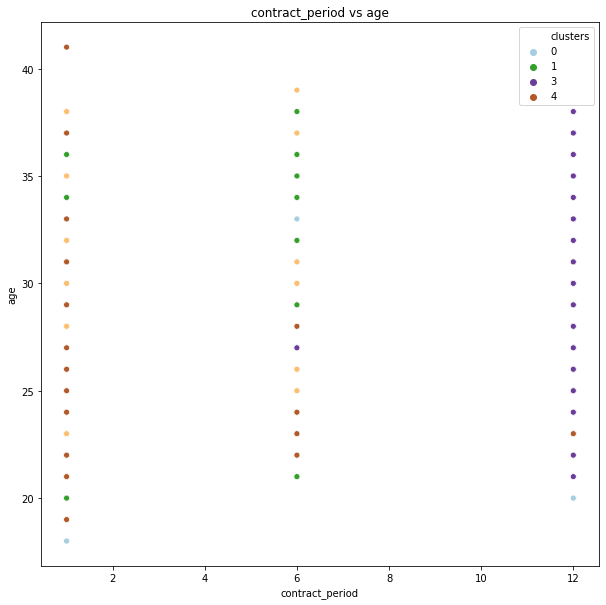

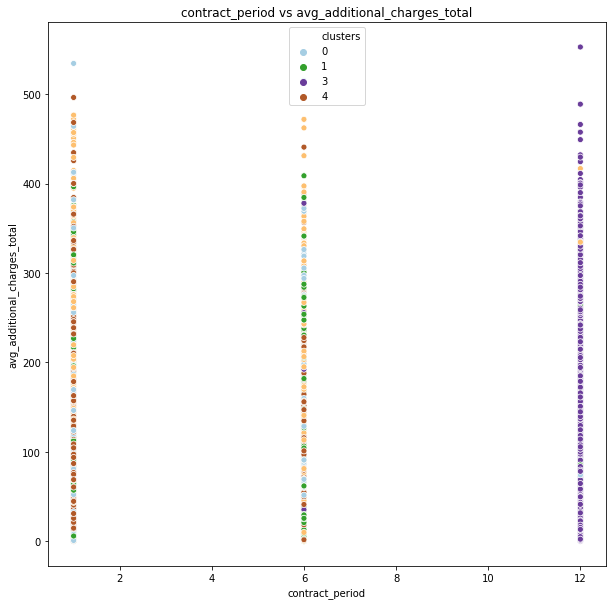

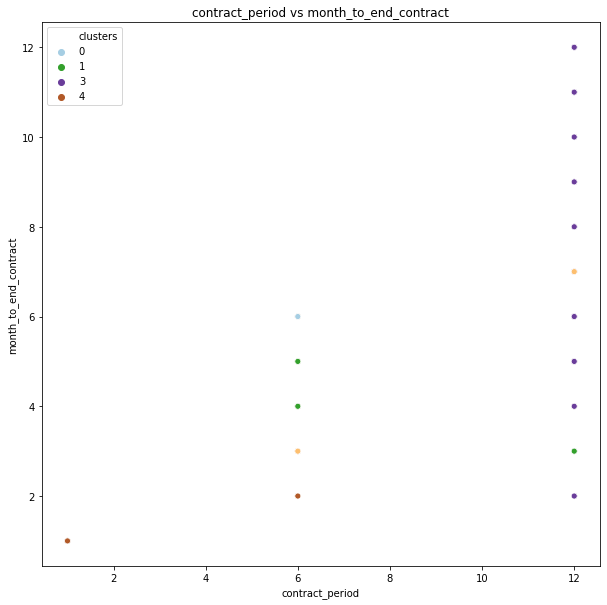

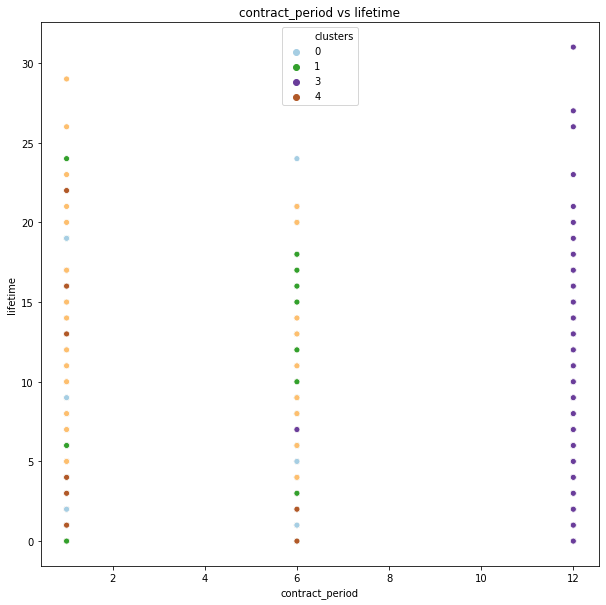

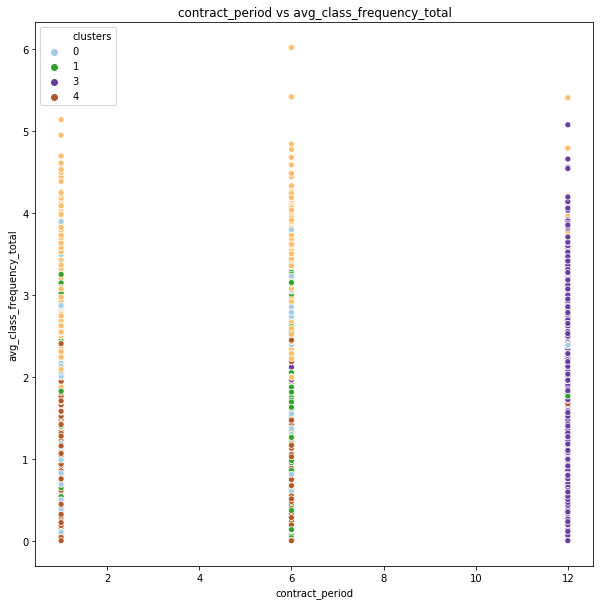

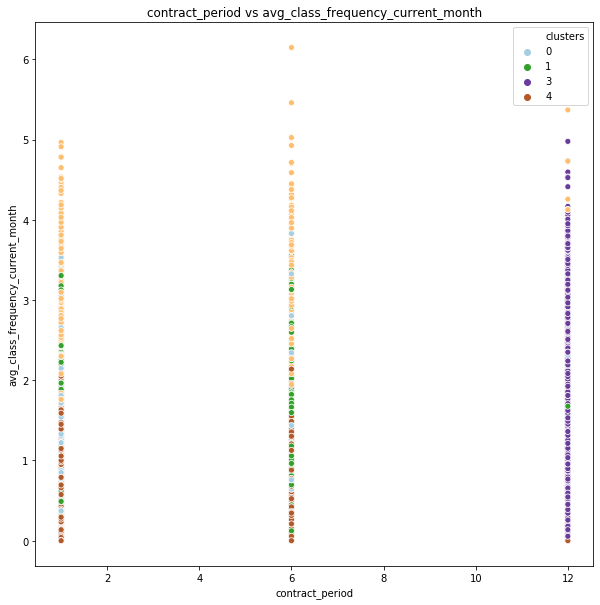

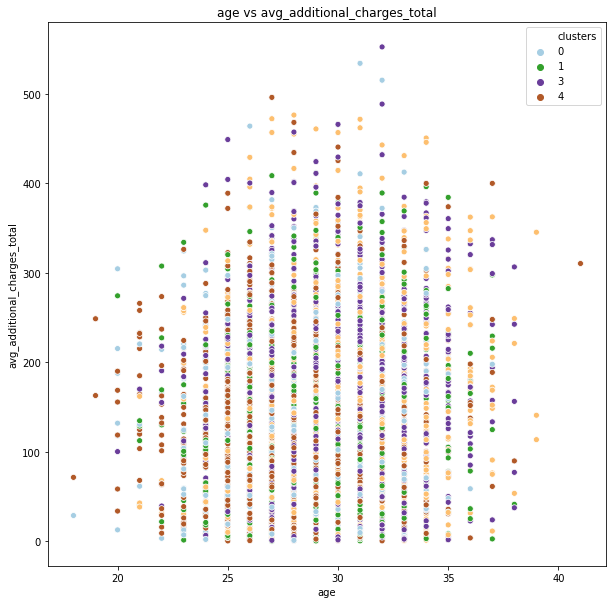

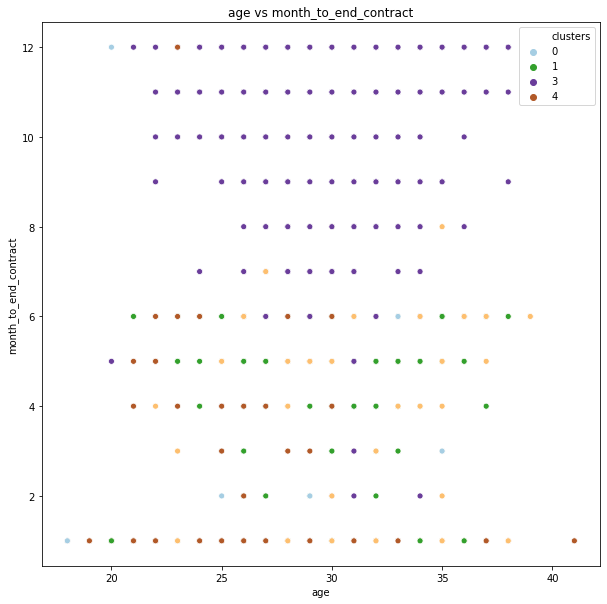

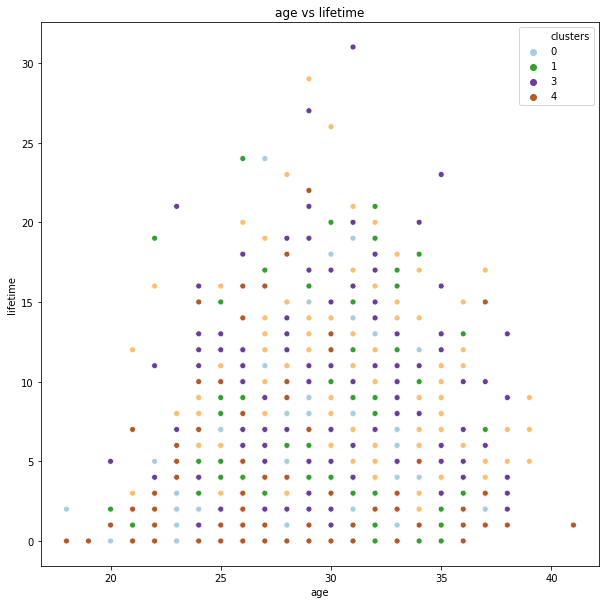

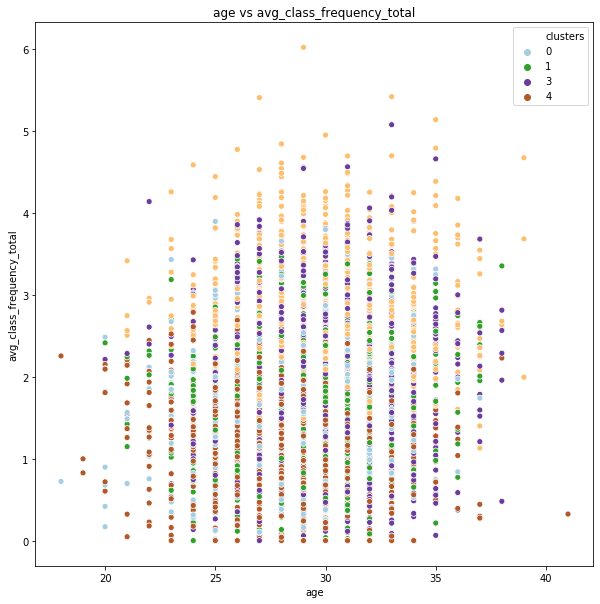

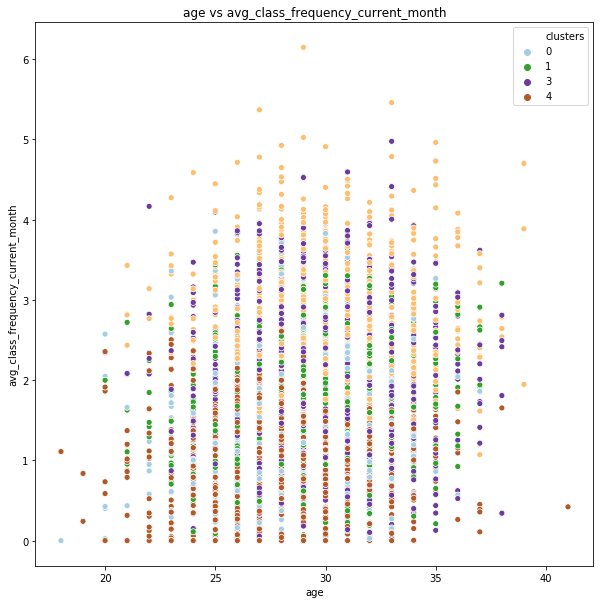

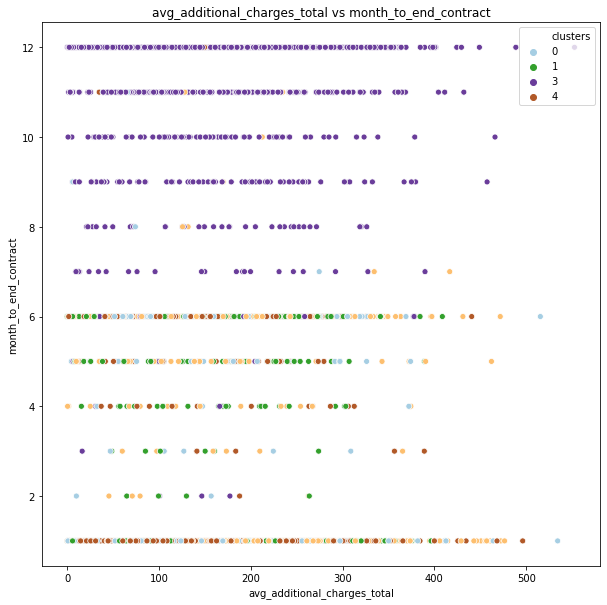

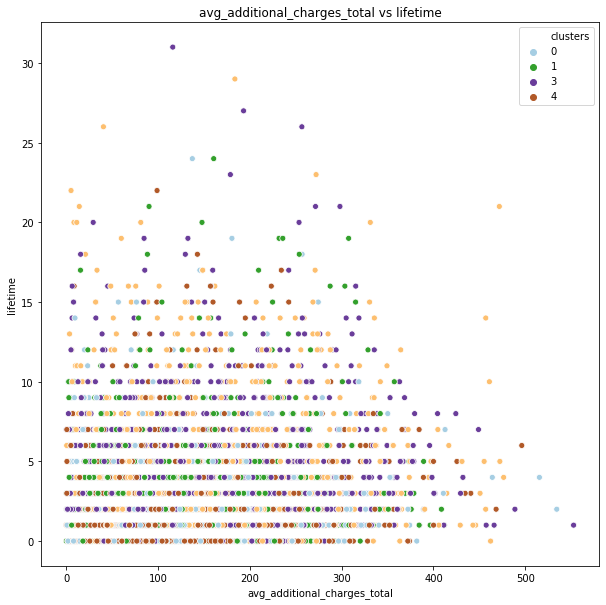

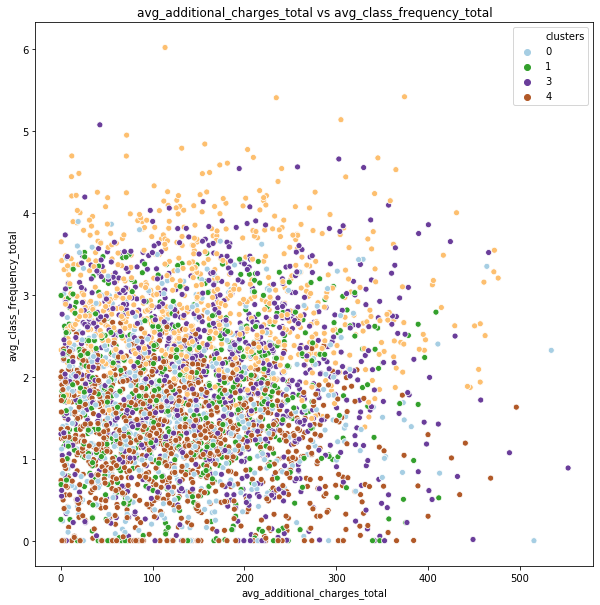

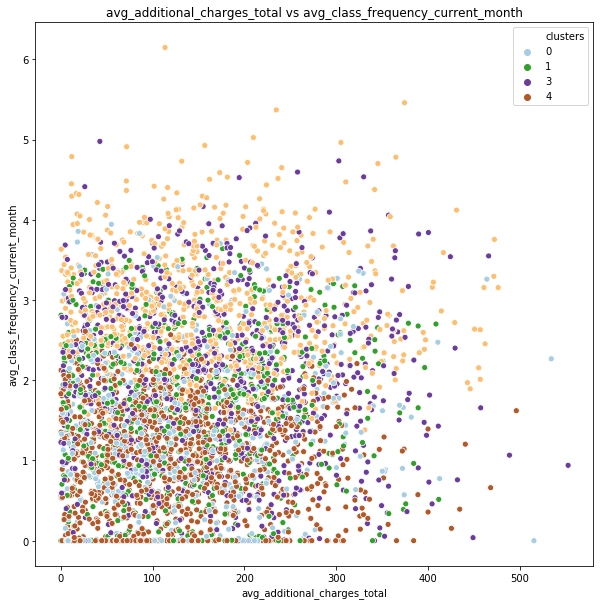

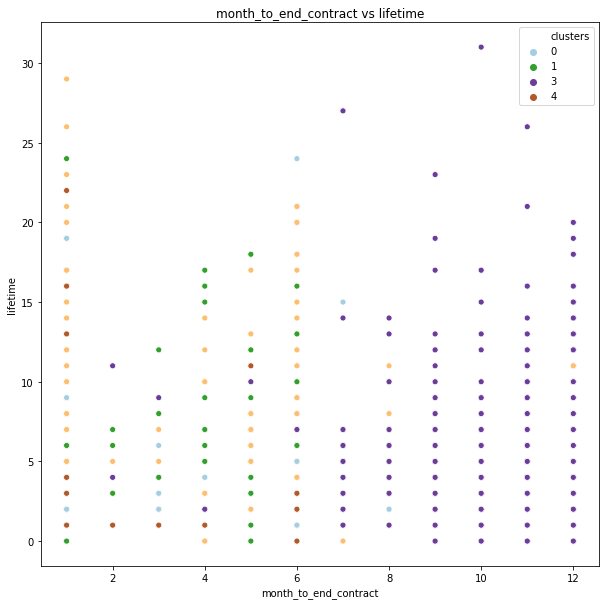

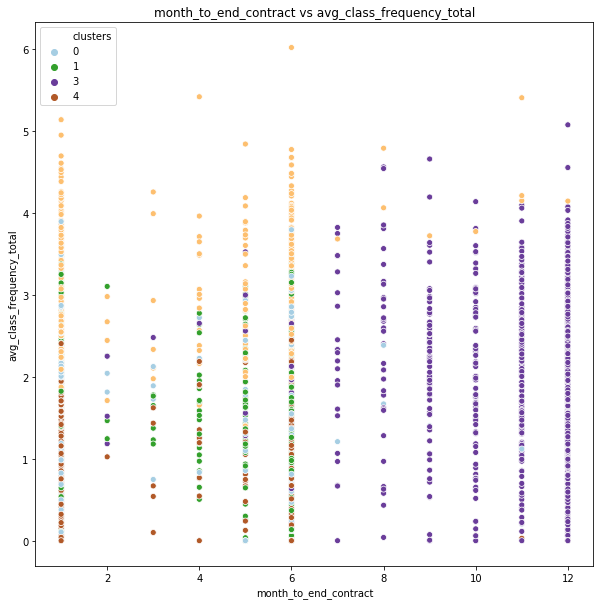

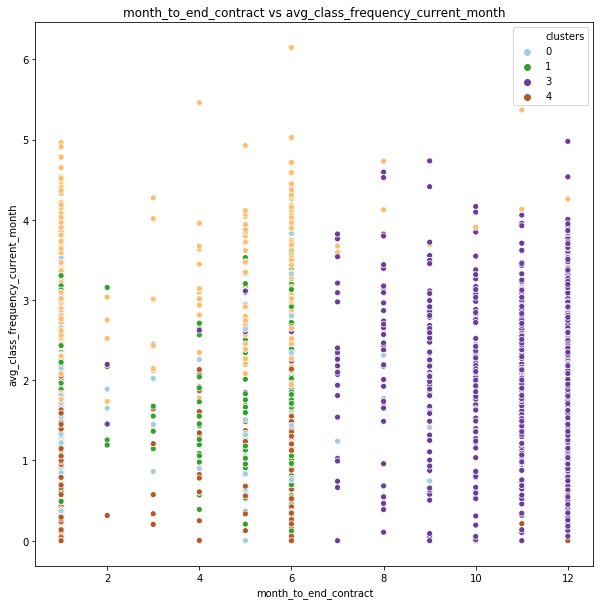

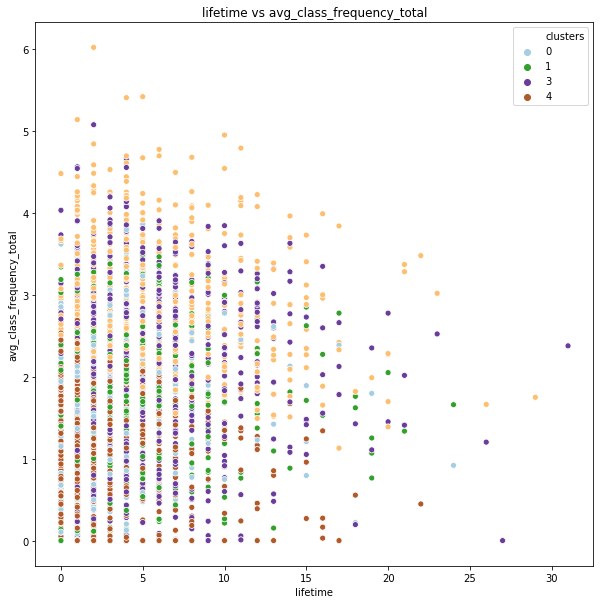

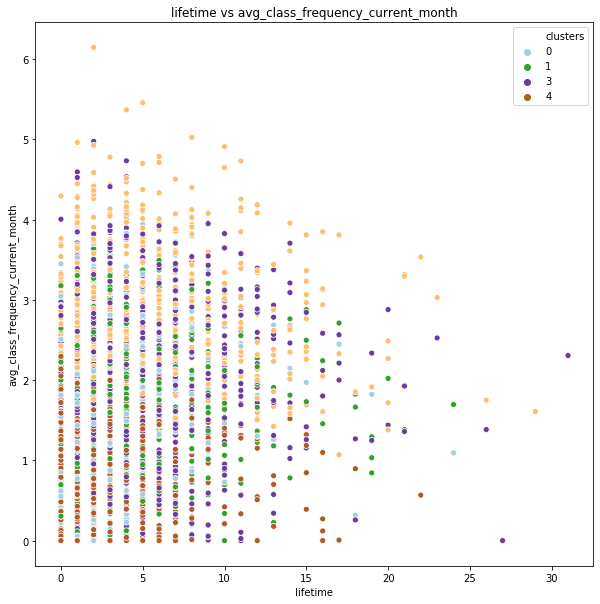

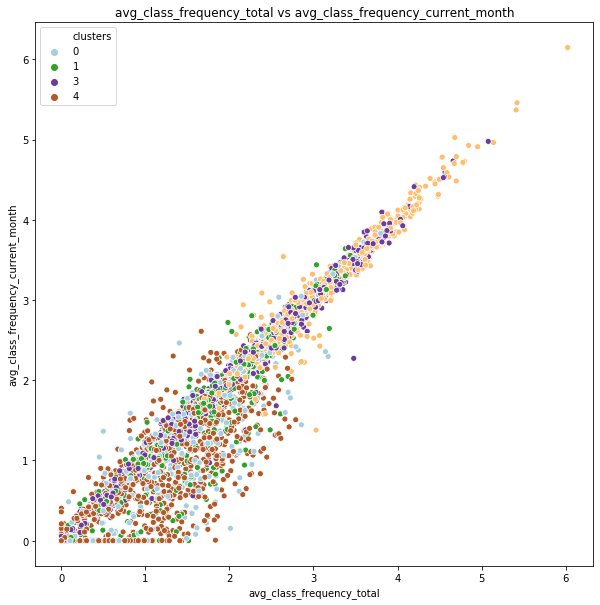

In [25]:
from itertools import combinations
numerical_columns = ['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 
                    'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month'] #рассмотрим только
#колличественные переменные
columns_combinations = list(combinations(numerical_columns, 2))
for (col_a, col_b) in columns_combinations:
    show_clusters_on_plot(fit_data, col_a, col_b, 'clusters')

# Вывод по блоку "Кластеризация"

Самые сильные зависимости, влияющие на "удержание":
- Посещение зала в разрезе месяца и всего времени действия абонемента
- Регулярное и частое посещение зала + общая длительность членства
- Регулярное и частое посещение зала + сумма доппродаж
- Регулярное и частое посещение зала + длительность абонимента

# Общий вывод

Для удержания клиентов стоит рассмотреть следующие рекомендации, основанные на анализе данных о пользователях клуба.

1. Важнейший показатель удержания - регулярность и частота посещения зала пользователем. На этот показатель можно влиять, основываясь на мотивации клиентов. Определить мотивацию поможет опрос мнения. Групповые занятия, поддержка сообщества, личные и спортивные цели - важно понимать ЧТО важно клиенту при выборе места для тренировок и ЧТО заставит клиента ходить чаще. На основе опроса, стоит провести соответствующие изменения, либо усиление сильных сторон. 
Так же, на частоту и регулярность влиеяет уровень сервиса. Об удовлетворенности также можно узнать, опираясь на опрос мнения.

2. Стоит рассмотреть систему лояльности (накопительную) для постоянных "старых" клиентов. Которая мотивировали бы при оформлении нового вбонимента, оставаться в привычном месте. ВозможноЮ, растущая скидка, либо бонусы на дополнительные продукты.

3. Дополнительные продукты. Продавать больше и чаще. Продавать то, что дубут покупать. Узнать - опрос мнения у клиентов. 

4. Длительность абонимента. Обучить отдел продаж на заключение договоров с бОльшей длительностью. Рання проработка клиентов, скидочная политика, kpi на продажу годовых абониментов.